In [1]:
import scoops
import MDAnalysis as mda
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

## Load the data
The SCOOPS workflow uses MDAnalysis to load MD data.  This example notebook uses a multiframe PDB file.  MDAnalysis can also load several other formats, e.g. `u = mda.Universe("test_psf.psf", ["test_dcd_1.dcd, "test_dcd_2.dcd"])`.  See the MDAnalysis documentation for more details.

In [2]:
u = mda.Universe("mpro_short_traj.pdb")

/Users/danielevans/Desktop/work/lau/vols_and_diheds/mdanalysis_with_bug_fix/mdanalysis/package/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


## Select the binding site location.
Our example protein is SARS-CoV-2 main protease.  It is a homodimer; each chain's active site has two catalytic residues.  We will define our binding site's center as the center of mass of chain A's catalytic residues.  The site's edge will be a sphere with radius 9 Angstroms.

SCOOPS divides space into a 3D grid of cubes called voxels.  Proteins and binding pockets are defined as collections of filled voxels.  See below for a representation of this.

The volume-calculation procedure has several steps:
* Create a voxelized protein surface.  This is stored as a ProteinSurface object.
* Create a sphere with the correct center and radius.  This is stored as a VoxelGrid object.
* "Subtract" the protein surface from the sphere, by finding all regions of the sphere that are not part of the protein.
* Optional: remove everything from the pocket except for the largest contiguous shape.

Note that a newly created MDAnalysis Universe is initialized at the first frame of the trajectory.  Thus our notebook will find the site in the first frame.

In [3]:
# Voxelize the protein.
grid_size = 1 # Side length of the voxel grid (in Angstroms)
prot_atoms = u.select_atoms("protein") # Select the protein atoms (i.e. not any solvent or ligand).
protein_surf = scoops.volumes.ProteinSurface(prot_atoms, solvent_rad=1.09, grid_size=grid_size)

# Define the binding site as a sphere.
active_site_atoms = u.select_atoms("segid PROA and (resid 41 or resid 145)")
active_site_center = active_site_atoms.center_of_mass()
sphere_voxel = scoops.volumes.generate_voxelized_sphere(9, active_site_center, grid_size)

# Subtract the protein surface from the sphere.
pocket_shape = scoops.volumes.voxel_subtract(sphere_voxel, protein_surf.surf)

# Get the largest shape.
pocket_shape = scoops.volumes.get_largest_shape(pocket_shape)

## View the binding site.
It is important to check that the binding site looks reasonable.  We want to view both the protein (a `ProteinSurface`) and the pocket (a `VoxelGrid`).  This is done with the function `show_in_jupyter`.

The controls for zooming, rotating, etc. may vary between computers.  On my Mac laptop, the controls are as follows:
* Rotate screen: click and drag.
* Zoom: pinch in/out with two fingers, or slide up/down with two fingers.
* Drag camera: press and hold shift; while holding, click and drag.

Additional notes:
* The initial viewing angle might be bad.  You'll probably need to zoom out.
* If no window shows up, you might need to downgrade a library called `ipywidgets`.  This is due to a known bug in a SOOPS dependency, as described [here](https://github.com/pyvista/pyvista/issues/3274).  Running the command `pip install ipywidgets==7.7.1` should fix the issue.
* If you are running the Jupyter notebook on a remote server, you'll need to run `import pyvista as pv` and `pv.start_xvfb()` to view the protein.  Viewing the protein remotely can have severe lag, so it should be avoided when possible.
* Alternatively, you can output the voxelized shapes to PDB files using `write_voxels_to_pdb`.  E.g. `write_voxels_to_pdb(protein_surf.surf, "protein.pdb")` and `write_voxels_to_pdb(pocket_shape, "pocket.pdb")`.
* When grid_size is small (e.g. 0.5), passing large selections to `sel_regions` can dramatically slow down the code's runtime.

In [4]:
# Uncomment the pyvista xvfb lines if running on remote server. 
#import pyvista as pv
#pv.start_xvfb()

sel_regions={u.select_atoms("segid PROA and (resid 41 or resid 145)") : "green",
             u.select_atoms("segid PROB") : "orange"}

prot_viewer = scoops.volumes.show_in_jupyter(protein_surf, sel_regions_1=sel_regions,
                                             object_2=pocket_shape)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [5]:
prot_viewer.set_background("white")

## Align the trajectory.
The SCOOPS volume calculator is very sensitive to how the trajectory is aligned.  It is not enough to align the trajectory using a global alignment; you should align using just the pocket region.  This way if the entire pocket changes location (e.g. due to domain motion), this won't impact the results.

SCOOPS includes a function to automatically align to a pocket.  It finds all atoms that border the pocket, and aligns each frame to these atoms' positions in the first frame.  It writes the aligned trajectory to a file, and returns an MDAnalysis Universe of that file.  The output file can be either PDB format or (if `psf_loc` is also provided) DCD format.

In [6]:
copy_filename = "aligned.pdb"
u_copy = scoops.volumes.align_to_pocket(protein_surf, pocket_shape, u,
                                               copy_filename, 0)

protein_in_copy = u_copy.select_atoms("protein")

/Users/danielevans/Desktop/work/lau/vols_and_diheds/mdanalysis_with_bug_fix/mdanalysis/package/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/Users/danielevans/Desktop/work/lau/vols_and_diheds/mdanalysis_with_bug_fix/mdanalysis/package/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/danielevans/Desktop/work/lau/vols_and_diheds/mdanalysis_with_bug_fix/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/danielevans/Desktop/work/lau/vols_and_diheds/mdanalysis_with_bug_fix/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for

## Get the pocket volume of each frame.

At each frame, find the voxelized protein surface and subtract it from the pocket sphere.  Store the results in lists.

WARNING: for long trajectories, storing the voxelized protein and pocket shapes of each frame can use too much memory.  It may be necessary to only store the volumes (in cubic Angstroms) of each frame, and then re-find the voxelized surfaces for frames of interest.

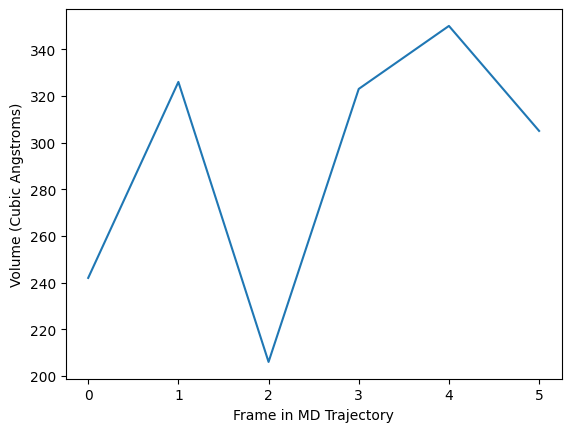

In [7]:
volumes = []
pockets = []
prots = []
for frame in u_copy.trajectory[0:6]:
    prot_this_frame = scoops.volumes.ProteinSurface(protein_in_copy, solvent_rad=1.09, grid_size=grid_size)
    pocket_this_frame = scoops.volumes.voxel_subtract(sphere_voxel, prot_this_frame.surf)
    pocket_this_frame = scoops.volumes.get_largest_shape(pocket_this_frame)
    volumes.append(pocket_this_frame.volume)
    pockets.append(pocket_this_frame)
    prots.append(prot_this_frame)

plt.plot(volumes)
plt.xlabel("Frame in MD Trajectory")
plt.ylabel("Volume (Cubic Angstroms)")
plt.show()